## Vector Autoregression

In [46]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplolib', 'inline')
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.3f}'.format

plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

In [47]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

In [48]:
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')

ans.head()

,ano,cd_ops,trimestre,receita,despesa,benef,modalidade,port_ops,contratacao
0,2018,303976,2018Q1,29314392.257,23298026.978,27209,Cooperativa Médica,Grande,Adesao
1,2018,342084,2018Q1,100884002.783,71227129.017,50901,Cooperativa Médica,Grande,Adesao
2,2018,348295,2018Q2,4388045.611,4255788.457,6692,Cooperativa Médica,Grande,Adesao
3,2018,348295,2018Q3,4596013.001,4967336.847,6736,Cooperativa Médica,Grande,Adesao
4,2018,348295,2018Q4,4842097.207,3878879.670,7581,Cooperativa Médica,Grande,Adesao


In [49]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup.set_index('trimestre', inplace=True)

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,2.150,1.580,1655264,38,73.490
2018Q2,2.160,1.640,1667369,38,75.930
2018Q3,2.290,1.850,1678692,38,80.790
2018Q4,2.380,1.250,1693379,38,52.520
2019Q1,2.370,1.870,1700602,38,78.900
2019Q2,2.460,1.980,1730500,38,80.490
2019Q3,2.550,1.950,1733529,38,76.470
2019Q4,2.650,2.080,1757501,38,78.490
2020Q1,2.750,2.100,1876410,39,76.360


In [50]:
ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 2018Q1 to 2021Q4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   receita      16 non-null     float64
 1   despesa      16 non-null     float64
 2   benef        16 non-null     int32  
 3   n_ops        16 non-null     int32  
 4   pct_despesa  16 non-null     float64
dtypes: float64(3), int32(2)
memory usage: 640.0+ bytes


In [51]:
columns = ['receita','despesa']

#Correlação de Pearson entre receita e despesa (Antes da diferenciação)

stats.pearsonr(ans_agrup['receita'],ans_agrup['despesa'])

(0.8883356732978733, 4.300311285509653e-06)

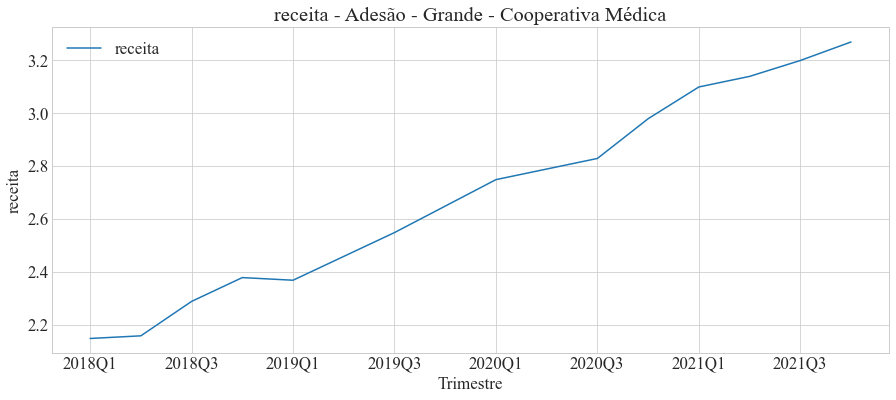

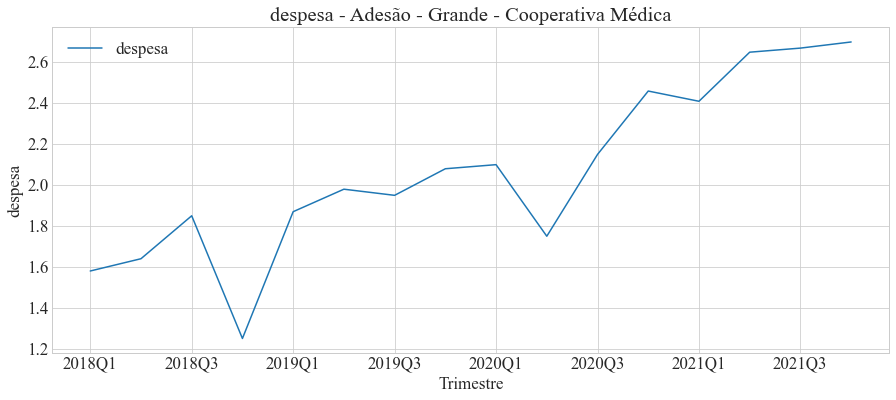

In [52]:
for c in ans_agrup[columns]:
    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

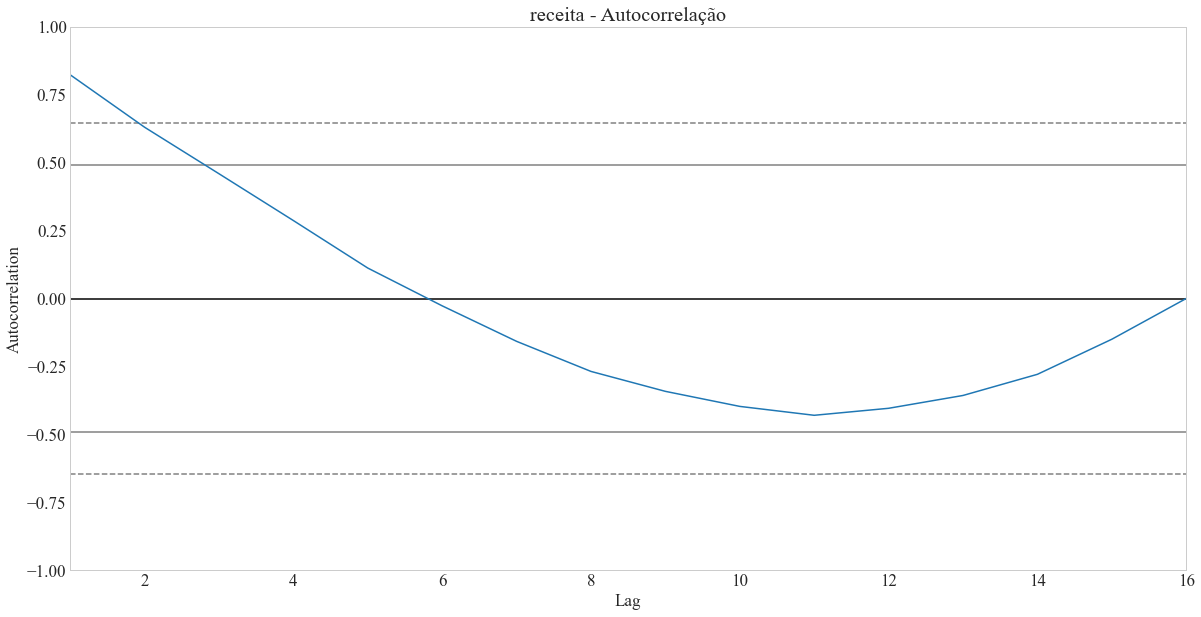

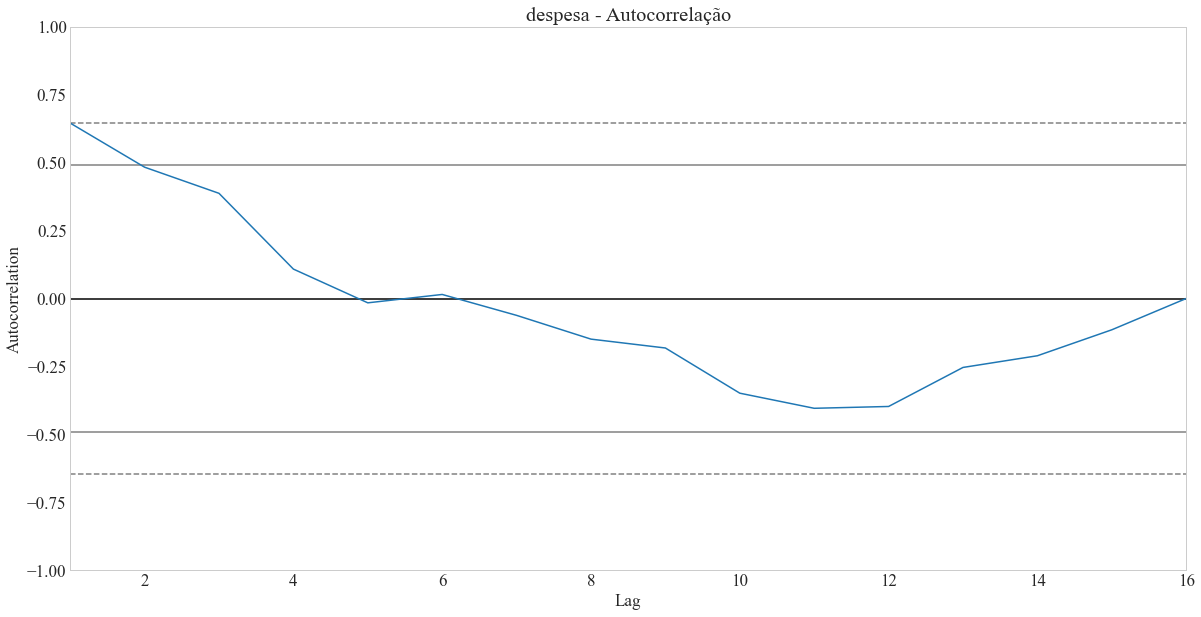

In [53]:
for c in ans_agrup[columns]:
    pd.plotting.autocorrelation_plot(ans_agrup[str(c)])
    plt.title(f'{str(c)} - Autocorrelação')
    plt.show()

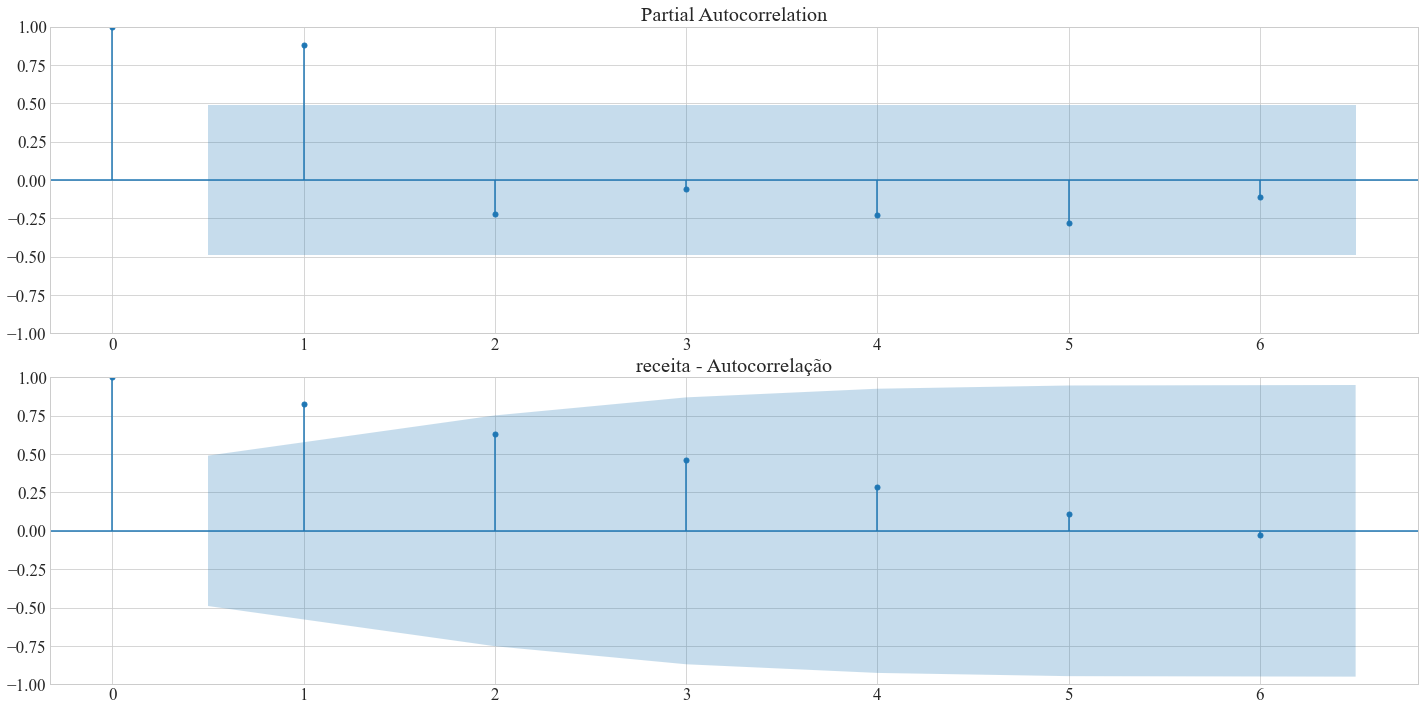

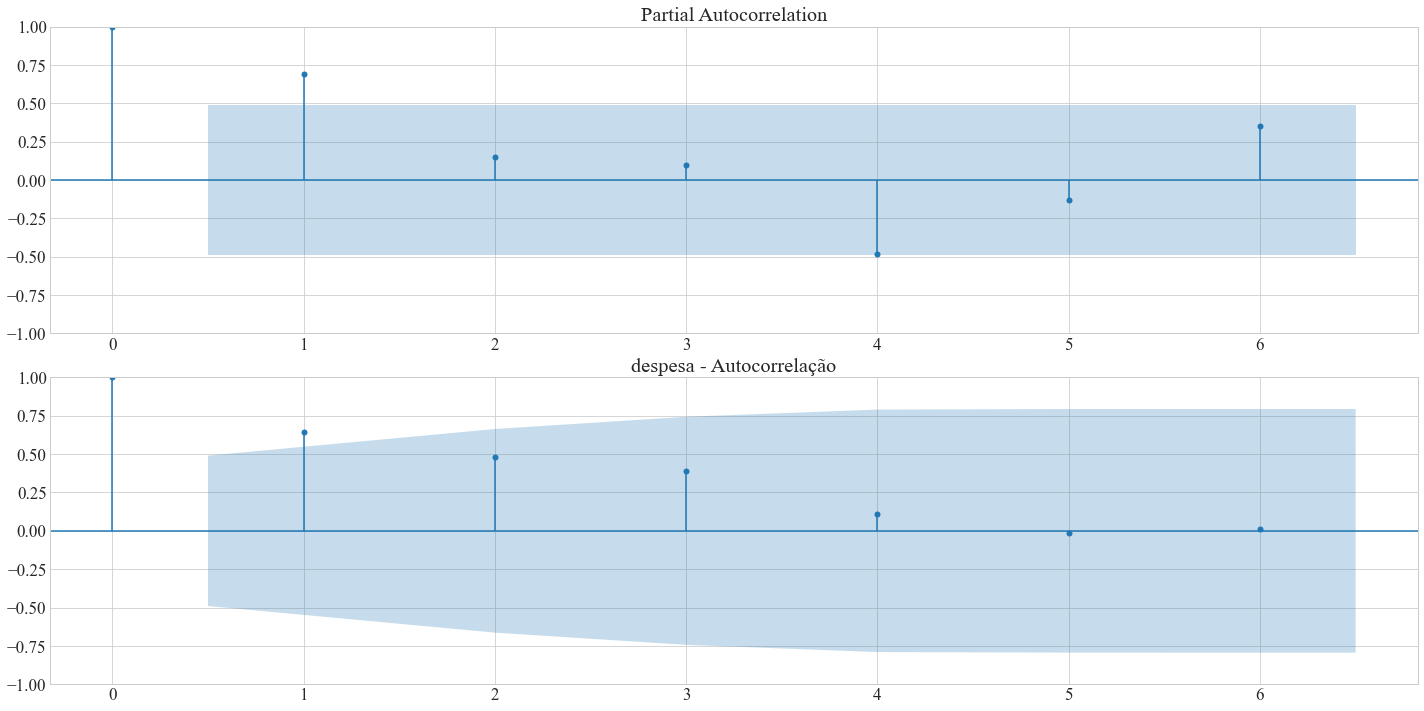

In [62]:
from matplotlib.pyplot import tight_layout

for c in ans_agrup[columns]:
    fig,axs = plt.subplots(2)
    fig,tight_layout()
    sm.graphics.tsa.plot_pacf(ans_agrup[str(c)], lags=6, ax=axs[0])
    plt.title(f'{str(c)} - Autocorrelação')   
    sm.graphics.tsa.plot_acf(ans_agrup[str(c)], lags=6, ax=axs[1])
    plt.title(f'{str(c)} - Autocorrelação')

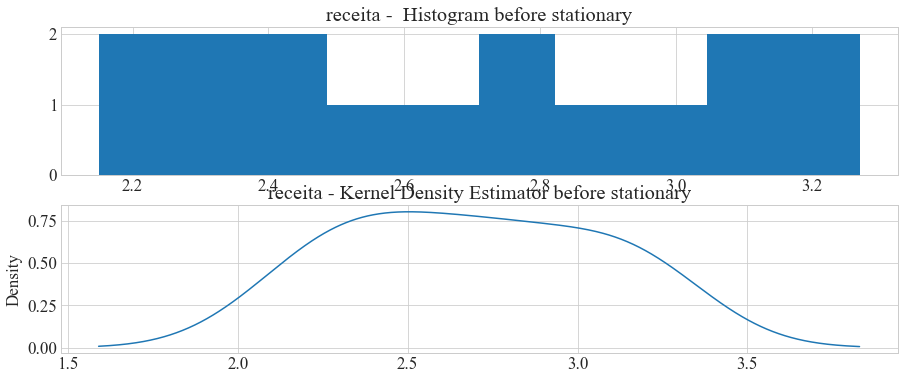

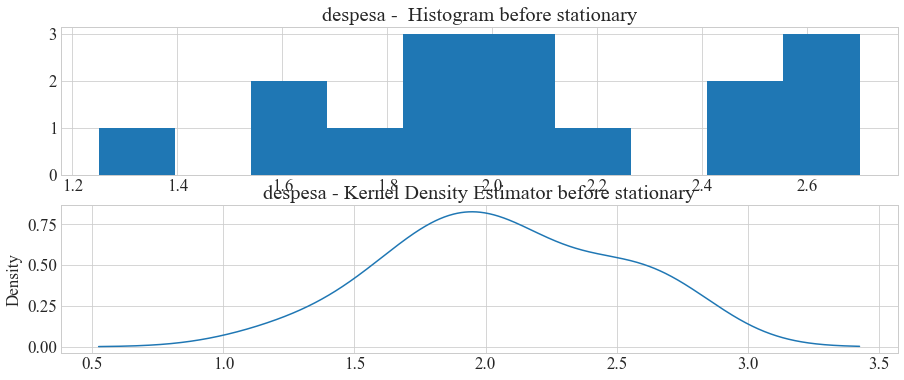

In [ ]:
for c in ans_agrup[columns]:
    ans_agrup[str(c)].plot(figsize=(15,6))
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f'{str(c)} -  Histogram before stationary')
    ans_agrup[str(c)].hist()
    plt.subplot(212)
    ans_agrup[str(c)].plot(kind='kde')
    plt.title(f'{str(c)} - Kernel Density Estimator before stationary')
    plt.show()

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
    
    print(f'Mean Squared Error (MSE) is : {metrics.mean_squared_error(y_true,y_pred)}')

    print(f'Mean Absolute Error (MAE) is : {metrics.mean_absolute_error(y_true,y_pred)}')

    print(f'Root Mean Squared Error (MAE) is : {np.sqrt(metrics.mean_squared_error(y_true,y_pred))}')

    print(f'Coefficient of determination R^2 is : {metrics.r2_score(y_true,y_pred)}', end = '\n\n')

    return


def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')

In [ ]:
for name, column in ans_agrup[columns].iteritems():

    Augmented_Dickey_Fuller_Test_func(ans_agrup[name], name)

    print('\n')

Results of Dickey-Fuller Test for column receita
Test Statistic                 -0.035
p-value                         0.956
No Lags Used                    6.000
Number of Observartions Used    9.000
Critical Value (1%)            -4.473
Critical Value (5%)            -3.290
Critical Value (10%)           -2.772
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column despesa
Test Statistic                  2.344
p-value                         0.999
No Lags Used                    5.000
Number of Observartions Used   10.000
Critical Value (1%)            -4.332
Critical Value (5%)            -3.233
Critical Value (10%)           -2.749
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




In [ ]:
X = ans_agrup[columns]

train, test = X[0:-3], X[-3:]

train_diff = train.diff()

train_diff['receita'] = train_diff['receita'].diff()

display(train_diff)

train_diff.dropna(inplace = True)

display(train_diff)

,receita,despesa
trimestre,,
2018Q1,NaN,NaN
2018Q2,NaN,0.060
2018Q3,0.120,0.210
2018Q4,-0.040,-0.600
2019Q1,-0.100,0.620
2019Q2,0.100,0.110
2019Q3,0.000,-0.030
2019Q4,0.010,0.130
2020Q1,0.000,0.020


,receita,despesa
trimestre,,
2018Q3,0.120,0.210
2018Q4,-0.040,-0.600
2019Q1,-0.100,0.620
2019Q2,0.100,0.110
2019Q3,0.000,-0.030
2019Q4,0.010,0.130
2020Q1,0.000,0.020
2020Q2,-0.060,-0.350
2020Q3,0.000,0.400


In [ ]:
test

,receita,despesa
trimestre,,
2021Q2,3.140,2.650
2021Q3,3.200,2.670
2021Q4,3.270,2.700


In [ ]:
for name, column in train_diff[columns].iteritems():

    Augmented_Dickey_Fuller_Test_func(train_diff[name], name)

    print('\n')

Results of Dickey-Fuller Test for column receita
Test Statistic                 -3.312
p-value                         0.014
No Lags Used                    3.000
Number of Observartions Used    7.000
Critical Value (1%)            -4.939
Critical Value (5%)            -3.478
Critical Value (10%)           -2.844
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column despesa
Test Statistic                 -4.642
p-value                         0.000
No Lags Used                    1.000
Number of Observartions Used    9.000
Critical Value (1%)            -4.473
Critical Value (5%)            -3.290
Critical Value (10%)           -2.772
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




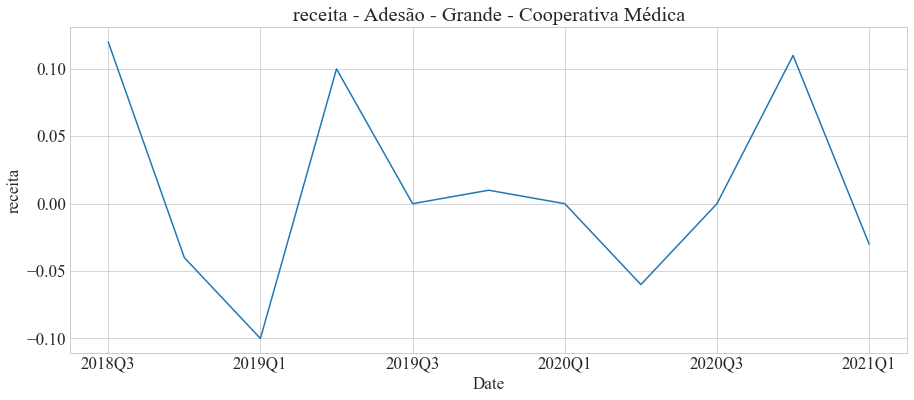

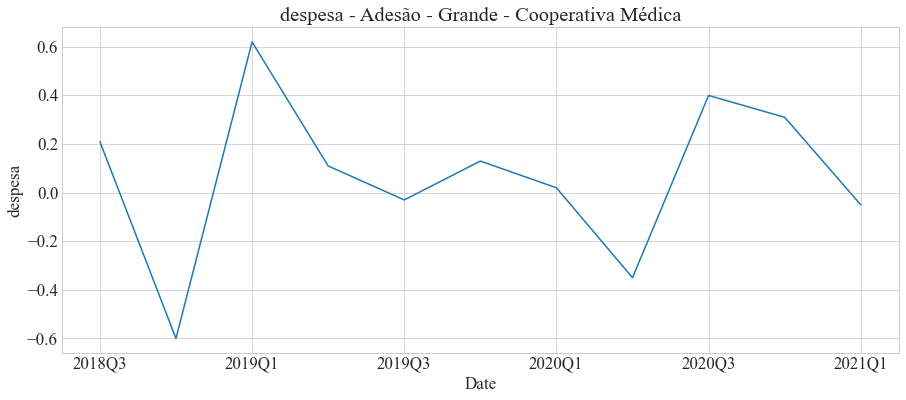

In [ ]:
for c in train_diff[columns]:
    train_diff[str(c)].plot(figsize=(15,6))
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

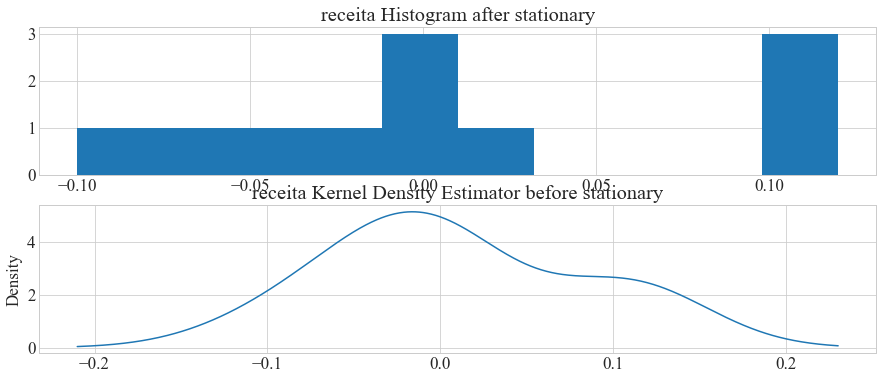

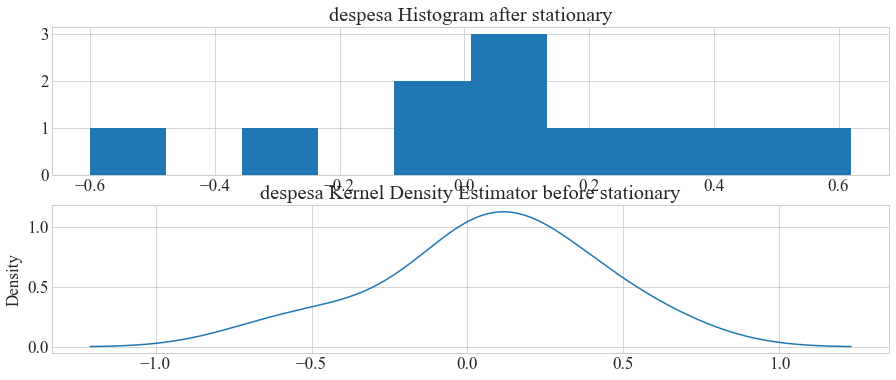

In [ ]:
for c in train_diff[columns]:
    train_diff[str(c)].plot(figsize=(15,6))
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f'{str(c)} Histogram after stationary')
    train_diff[str(c)].hist()
    plt.subplot(212)
    train_diff[str(c)].plot(kind='kde')
    plt.title(f'{str(c)} Kernel Density Estimator before stationary')
    plt.show()

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegratrion_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]

    def adjust(val, length=6):
        return str(val).ljust(length)
    print('Column Name > Test Stat > C(95%)  =>  Signif \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2),9), '> ', adjust(cvt,8), '=> ', trace > cvt )

cointegratrion_test(train_diff[columns])


Column Name > Test Stat > C(95%)  =>  Signif 
 ----------------------------------------
receita >  11.92     >  12.3212  =>  False
despesa >  0.38      >  4.1296   =>  False


In [ ]:
for i in [1,2,3,4,5,6,7,8,9]:
    model = VAR(train_diff)
    results = model.fit(i)
    print(f'Order: {i}, AIC: {results.aic}, BIC: {results.bic}')

Order: 1, AIC: -8.977126461190302, BIC: -8.795575405393876
Order: 2, AIC: -8.760771806059015, BIC: -8.541633386796548
Order: 3, AIC: -44.789293073607936, BIC: -44.65027037566822
Order: 4, AIC: -138.63636682402924, BIC: -138.77545501217273
Order: 5, AIC: -141.69960906837, BIC: -142.46315768120047
Order: 6, AIC: -134.72315698154856, BIC: -136.75407983689124
Order: 7, AIC: -133.1421557638697, BIC: -137.74494805547053
Order: 8, AIC: -127.63513014294858, BIC: -137.85085753804333
Order: 9, AIC: -113.30296550769458, BIC: -138.1331690770556


In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

In [ ]:
results = model.fit(1)
display(results.summary())
z = results.forecast(y=train_diff[columns].values, steps=3)
df_pred = pd.DataFrame(z, columns=columns)
df_pred["new_index"] = range(13,16)
df_pred = df_pred.set_index('new_index')

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Oct, 2022
Time:                     17:28:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.79558
Nobs:                     10.0000    HQIC:                  -9.17629
Log likelihood:           22.5069    FPE:                0.000131166
AIC:                     -8.97713    Det(Omega_mle):     7.76129e-05
--------------------------------------------------------------------
Results for equation receita
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.007291         0.013077           -0.558           0.577
L1.receita        -0.406523         0.180926           -2.247           0.025
L1.despesa         0.146129         0.037994            3.846         

In [ ]:
actual_df = ans_agrup[columns]

res = inverse_diff(actual_df,df_pred)

res

,receita,despesa,receita_1st_inv_diff,despesa_1st_inv_diff
new_index,,,,
13,-0.002,0.220,3.268,2.920
14,0.026,0.050,3.293,2.970
15,-0.010,0.036,3.283,3.006


In [ ]:
for i in columns:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)], res[str(i)+'_1st_inv_diff'])

Evaluation metric for receita
Mean Squared Error (MSE) is : 0.008394938321811917
Mean Absolute Error (MAE) is : 0.07801597534613203
Root Mean Squared Error (MAE) is : 0.09162389601960788
Coefficient of determination R^2 is : -1.9745844447365113

Evaluation metric for despesa
Mean Squared Error (MSE) is : 0.08567012024916511
Mean Absolute Error (MAE) is : 0.2922685025340888
Root Mean Squared Error (MAE) is : 0.29269458527476233
Coefficient of determination R^2 is : -201.90291637959933



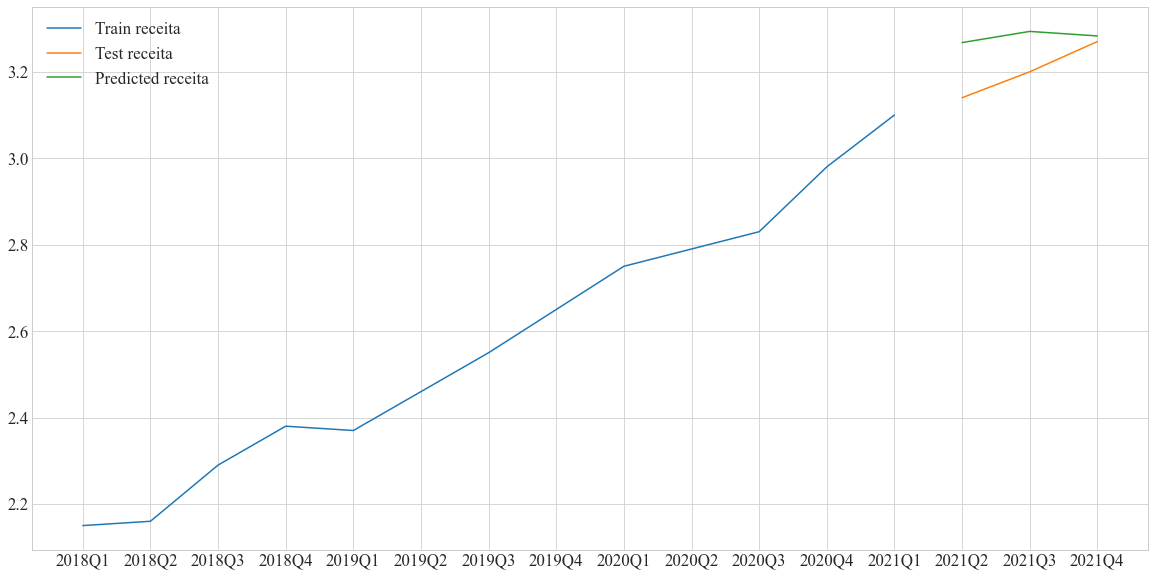

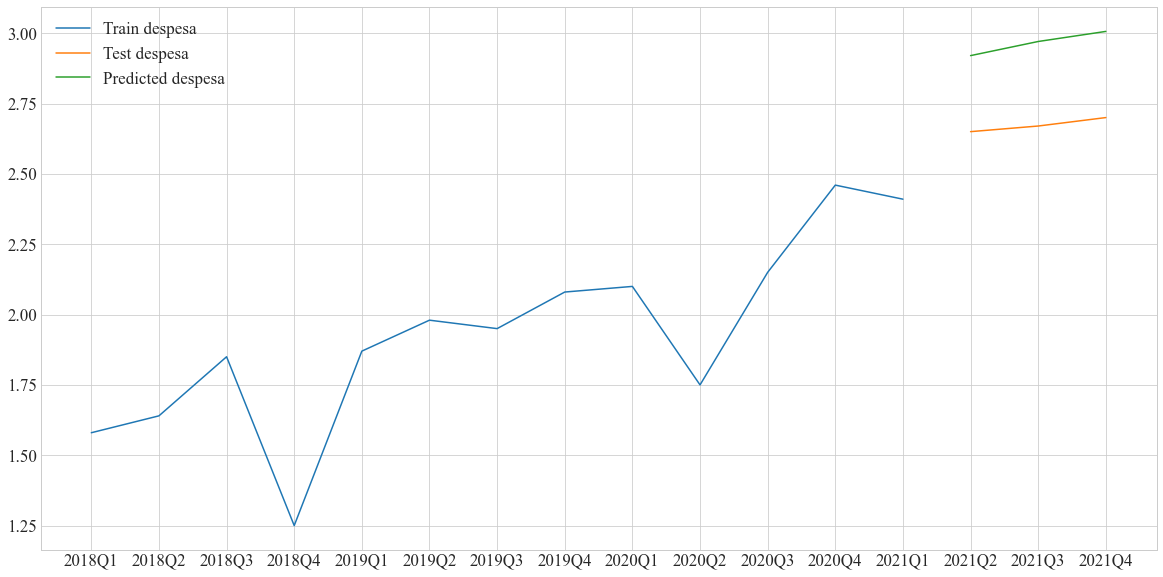

In [ ]:
for i in columns:
    plt.rcParams['figure.figsize'] = [20,10]
    plt.plot(train[i], label='Train '+i)
    plt.plot(test[i], label='Test '+i)
    plt.plot(res[i+'_1st_inv_diff'], label = 'Predicted '+i)
    plt.legend(loc='best')
    plt.show()
